In [1]:
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
import logging
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.infer.autoguide.guides import AutoGuideList,AutoGuide
import numpy as np

from pyro.infer import MCMC, NUTS

In [2]:
# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)
n_steps = 2 if smoke_test else 1000

assert pyro.__version__.startswith('1.8.6')

In [3]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

In [4]:
# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(60):
    data.append(torch.tensor(1.0))
for _ in range(40):
    data.append(torch.tensor(0.0))

In [5]:
def model(data):
    # define the hyperparameters that control the Beta prior
    alpha0 = pyro.param("alpha_q", torch.tensor(10.0))   #torch.tensor(10.0)
    beta0 = pyro.param("beta_q", torch.tensor(15.0))
    # sample f from the Beta prior
    f = pyro.sample("latent_fairness", dist.Beta(alpha0, beta0))
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the ernoulli likelihood
        pyro.sample("obs_{}".format(i), dist.Bernoulli(f), obs=data[i])
    return f

In [6]:
def guide_0(data):
    # register the two variational parameters with Pyro
    # - both parameters will have initial value 15.0.
    # - because we invoke constraints.positive, the optimizer
    # will take gradients on the unconstrained parameters
    # (which are related to the constrained parameters by a log)
    alpha_q = pyro.param("alpha_q", torch.tensor(15.0),
                         constraint=constraints.positive)
    beta_q = pyro.param("beta_q", torch.tensor(15.0),
                        constraint=constraints.positive)
    # sample latent_fairness from the distribution Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.Beta(alpha_q, beta_q))
    
# def guide_1(data):
#     nuts_kernel = NUTS(model)
#     mcmc = MCMC(
#         nuts_kernel,
#         num_samples=10,
#         warmup_steps=10,
#         num_chains=1,
#     )
#     mcmc.run(data)
#     samples = mcmc.get_samples()["latent_fairness"].mean()

In [7]:
# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)


guide = AutoGuideList(model)
guide.append(guide_0)
# guide.append(guide_1)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

In [8]:
losses= [] 
# do gradient steps
for step in range(n_steps):
    loss = svi.step(data)
    losses.append(loss)
    if step % 100 == 0:
        print(step)
        logging.info("Elbo loss: {}".format(loss))


0
100
200
300
400
500
600
700
800
900


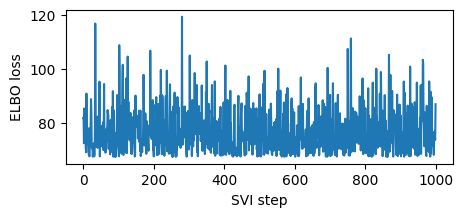

In [9]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [10]:
# grab the learned variational parameters
alpha_q = pyro.param("alpha_q").item()
beta_q = pyro.param("beta_q").item()

# here we use some facts about the Beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * math.sqrt(factor)

print("\nBased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))


Based on the data and our prior belief, the fairness of the coin is 0.417 +- 0.097


In [11]:
# pointless to run this on the mean
svi_data = [torch.tensor(model(data)) for i in range(100)]

nuts_kernel = NUTS(model)
mcmc = MCMC(
        nuts_kernel,
        num_samples=100,
        warmup_steps=100,
        num_chains=1,
    )
mcmc.run(svi_data)

D:\Python\Lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs_0
  warnings.warn(
D:\Python\Lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs_1
  warnings.warn(
D:\Python\Lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs_2
  warnings.warn(
D:\Python\Lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs_3
  warnings.warn(
D:\Python\Lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs_4
  warnings.warn(
D:\Python\Lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs_5
  warnings.warn(
D:\Python\Lib\site-packages\pyro\primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at obs_6
  warnings.warn(
D:\Python\Lib

Sample: 100%|█████████████████████████████████████████| 200/200 [00:14, 13.40it/s, step size=5.78e-01, acc. prob=0.947]


In [12]:
mcmc.get_samples()['latent_fairness'].mean()

tensor(0.4130)

In [13]:
out = np.array([model(data).detach().numpy() for i in range(100)])
out.mean()


0.40976933

In [ ]:
# maybe we turn it on its head
# use mcmc to generate data -> then train for SVI -> see if improved
# what we have here also works
# can do both